# Embedding and Filtering Inference 

Set default input and output directories according to local paths for data

In [1]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/shift_x_pre/" 

Import necessary libraries and functions

In [2]:
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
import time
# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial



In [3]:
noise_keep = ['0','0.2','0.4','0.6','0.8','1']
plt.rcParams.update({'axes.titlesize' : 16, 'axes.labelsize' : 16, 'lines.linewidth' : 2, 'lines.markersize' : 10,
                    'xtick.labelsize' : 14, 'xtick.major.width' : 2,
                    'ytick.labelsize' : 14, 'ytick.major.width' : 2,
                    'grid.alpha' : 0.5, "legend.frameon" : False, 'legend.fontsize' : 16})
noise_labels = [f'{float(n)*0.2*100:.0f}' for n in noise_keep]

## Adding Noise

In [4]:
# noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
# plot_noise_dist(noise_keep)
misl = [0.02,0.1,0.4,0.6,0.8,1]

## Embedding

Set checkpoint and other directory paths

In [5]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1' # needs to change...

Fixing some parameters

In [6]:
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

Load embedding model from checkpoint

In [7]:
emb_ckpt = torch.load(embed_ckpt_dir, map_location='cpu')
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']['knn_val'] = 500
emb_ckpt['hyper_parameters']['r_val'] = 1.7
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"knn_val":        500
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          1.7
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [8]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])
emb_model.load_state_dict(emb_ckpt["state_dict"])

<All keys matched successfully>

Put model in evaluation state

In [9]:
emb_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

Define embedding metrics (function gets metrics for one event)

In [10]:
def get_emb_metrics(data_path, emb_model,r_val=1.7,knn_val=500):
    data = torch.load(data_path)
    spatial = emb_model(torch.cat([data.cell_data, data.x], axis=-1))
    
    if(torch.cuda.is_available()):
        spatial = spatial.cuda()
        
    e_spatial = utils_torch.build_edges(spatial, r_val, knn_val)
    e_spatial_np = e_spatial.cpu().numpy()
    
    # remove R dist from out to in
    R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2)
    
    e_spatial_np = e_spatial_np[:, (R_dist[e_spatial_np[0]] <= R_dist[e_spatial_np[1]])]
    e_bidir = torch.cat([data.layerless_true_edges,torch.stack([data.layerless_true_edges[1],
                        data.layerless_true_edges[0]], axis=1).T], axis=-1)
    e_spatial_n, y_cluster = graph_intersection(torch.from_numpy(e_spatial_np), e_bidir)
    
    cluster_true = len(data.layerless_true_edges[0])
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial_n[0])
    purity = cluster_true_positive/cluster_positive
    eff = cluster_true_positive/cluster_true
    
    print("-----------")
    print(f"cluster true = {cluster_true}")
    print(f"cluste true positive = {cluster_true_positive}")
    print(f"cluster positive = {cluster_positive}")
    print(f"purity = {purity}")
    print(f"efficiency = {eff}")
    
    return purity, eff

In [11]:
def get_lvl_emb(mypath,emb_model,r_val=1.7,knn_val=500):
    events = [f for f in listdir(mypath) if isfile(join(mypath, f))][:5]
    p_lvl = []
    e_lvl = []
    for evt in events:
        data_path = join(mypath,evt)
        p, e = get_emb_metrics(data_path, emb_model,r_val,knn_val) 
        p_lvl.append(p)
        e_lvl.append(e)
    
    return np.mean(p_lvl), np.mean(e_lvl)

Metrics for one event and all noise configurations

In [12]:
%%time
p_all = []
e_all = []
misl = [0.02,0.1,0.4,0.6,0.8,1]
for i in misl:
    mypath = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/shift_x_pre/{i}/feature_store/"
    print(f"------ {i} ------")
    start = time.time()
    p,e = get_lvl_emb(mypath,emb_model)
    end = time.time()
    print(end-start)
    p_all.append(p)
    e_all.append(e)

------ 0.02 ------
-----------
cluster true = 113355
cluste true positive = 86453
cluster positive = 18630015
purity = 0.004640522296949305
efficiency = 0.762674782762119
-----------
cluster true = 103416
cluste true positive = 79130
cluster positive = 16981372
purity = 0.004659811939812637
efficiency = 0.7651620638972693
-----------
cluster true = 144803
cluste true positive = 107130
cluster positive = 24557033
purity = 0.004362497700760511
efficiency = 0.7398327382719971
-----------
cluster true = 109855
cluste true positive = 83171
cluster positive = 18072461
purity = 0.0046020849069753145
efficiency = 0.7570979928087024
-----------
cluster true = 120161
cluste true positive = 91122
cluster positive = 19996676
purity = 0.004556857349691519
efficiency = 0.7583325704679555
532.7740757465363
------ 0.1 ------
-----------
cluster true = 113355
cluste true positive = 86449
cluster positive = 18630299
purity = 0.004640236852881427
efficiency = 0.7626394953905871
-----------
cluster true =

In [13]:
pf = [ round(elem, 3) for elem in p_all ]
ef = [ round(elem, 3) for elem in e_all ]
e_all

[0.7566200296416087,
 0.7566114485758522,
 0.756575961763885,
 0.7565876857676265,
 0.7566255585268233,
 0.7566117282302258]

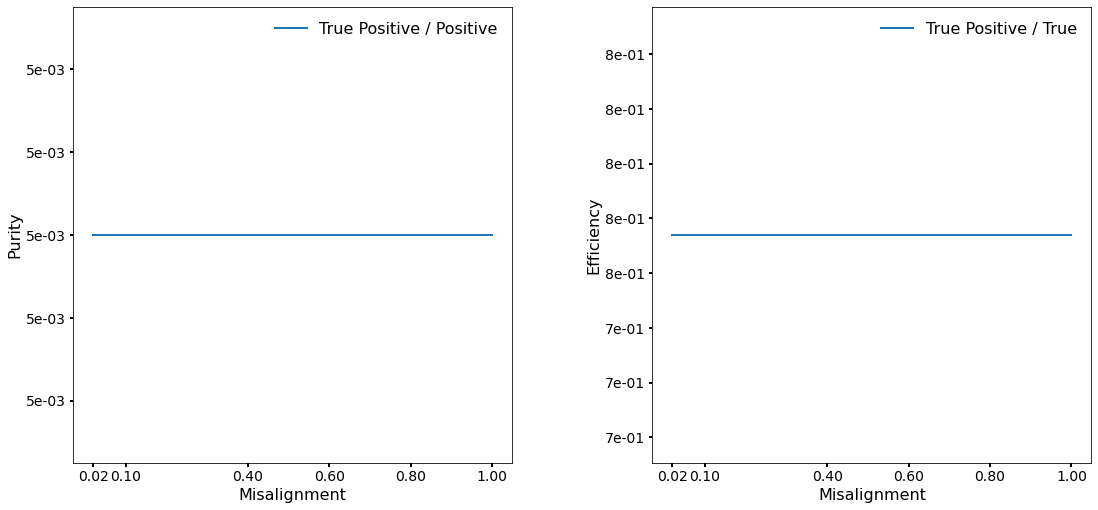

In [14]:
import matplotlib.ticker as ticker
x = np.arange(len(misl))
fig, (axn,axnn) = plt.subplots(1,2, figsize=(15,7))

# fig1.suptitle('Evt 1000')
fig.tight_layout(w_pad = 10)
axn.plot(misl, pf, label = 'True Positive / Positive')
axn.set_xlabel('Misalignment')
axn.set_ylabel('Purity')
axn.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
axn.set_xticks(misl)
axn.legend()

axnn.plot(misl, ef, label = 'True Positive / True')
axnn.set_xlabel('Misalignment')
axnn.set_ylabel('Efficiency')
axnn.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
axnn.set_xticks(misl)
axnn.legend()

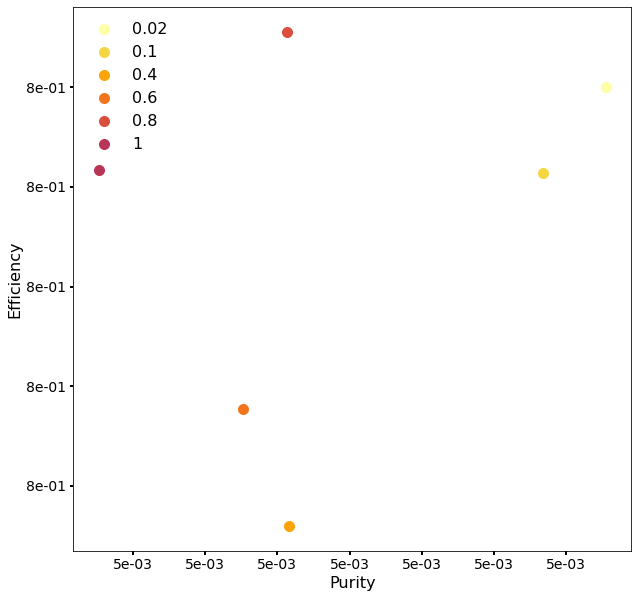

In [15]:
fig2, ax = plt.subplots(figsize=(10,10))
# fig2.suptitle(f'Eventid 1000, All noise, rval=1.7, knn=500')
colors = cm.inferno_r(np.linspace(0,5))
for i,mis in enumerate(misl):
    ax.scatter(p_all[i],e_all[i], color = colors[i], label = mis)
ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax.legend()

Average metrics for all events and all noise configurations

In [16]:
# p_avg = []
# e_avg = []
# for i in noise_keep:
#     data_path = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{i}/feature_store/'
#     p, e = get_lvl_emb(data_path,emb_model)
#     p_avg.append(p)
#     e_avg.append(e)

In [17]:
# x = np.arange(len(noise_keep))
# fig2, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
# fig2.tight_layout(w_pad = 10)
# fig2.suptitle('10 Events')
# ax1.plot(x, p_avg, label = 'True Positive / Positive')
# ax1.set_xlabel('noise_level')
# ax1.set_ylabel('Purity')
# ax1.set_xticks(x)
# ax1.set_xticklabels(noise_keep)
# ax1.legend()

# ax2.plot(x, e_avg, label = 'True Positive / True')
# ax2.set_xlabel('noise_level')
# ax2.set_ylabel('Efficiency')
# ax2.set_xticks(x)
# ax2.set_xticklabels(noise_keep)
# ax2.legend()

Tuning Hyperparameters `r_val = 1.7` and `knn_val = 500` with a set level of noise for a specific event.

* `r_val` defines the radius of the clustering method
* `knn_val` defines the number of maximum neighbors in the embedding space

In [18]:
# noise_lvl = 1
# evtid = 1000
# set_event = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest/out{noise_lvl}/feature_store/{evtid}'

In [19]:
rvals = np.arange(1,2,0.1)
ogp_val = []
oge_val = []
for n in rvals:
    data_path = "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n0/feature_store/"
    print(f"------ {n} ------")
    start = time.time()
    opv,oev = get_lvl_emb(data_path,emb_model,r_val=n)
    end = time.time()
    print(end-start)
    ogp_val.append(opv)
    oge_val.append(oev)

------ 1.0 ------
-----------
cluster true = 98107
cluste true positive = 85829
cluster positive = 486295
purity = 0.17649574846543764
efficiency = 0.8748509280683335
-----------
cluster true = 104909
cluste true positive = 91255
cluster positive = 558842
purity = 0.16329302378847688
efficiency = 0.8698491073215835
-----------
cluster true = 116478
cluste true positive = 101816
cluster positive = 660364
purity = 0.15418163315989364
efficiency = 0.8741221518226618
-----------
cluster true = 118662
cluste true positive = 103575
cluster positive = 658044
purity = 0.15739828947608367
efficiency = 0.8728573595590838
-----------
cluster true = 103195
cluste true positive = 90518
cluster positive = 528838
purity = 0.17116394812778205
efficiency = 0.877154900915742
380.7919144630432
------ 1.1 ------
-----------
cluster true = 98107
cluste true positive = 88958
cluster positive = 709387
purity = 0.1254012266929053
efficiency = 0.9067446767305085
-----------
cluster true = 104909
cluste true po

In [20]:
oge_val

[0.873766889537481,
 0.9051732499833607,
 0.927168436026925,
 0.943085497443749,
 0.954844758143544,
 0.9639935984329921,
 0.9708293757972255,
 0.9754627992526113,
 0.9784080701084479,
 0.9802499950509083]

In [21]:
%%time
rvals = np.arange(1,2,0.1)
p_val = []
e_val = []
for n in rvals:
    data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/shift_x_pre/1/feature_store/"
    print(f"------ {n} ------")
    start = time.time()
    pv,ev = get_lvl_emb(data_path,emb_model,r_val=n)
    end = time.time()
    print(end-start)
    p_val.append(pv)
    e_val.append(ev)

------ 1.0 ------
-----------
cluster true = 113355
cluste true positive = 74657
cluster positive = 5774015
purity = 0.012929824394290627
efficiency = 0.6586123241145075
-----------
cluster true = 103417
cluste true positive = 67977
cluster positive = 4974422
purity = 0.013665306240604436
efficiency = 0.6573097266406877
-----------
cluster true = 144799
cluste true positive = 93987
cluster positive = 8424697
purity = 0.01115612822633265
efficiency = 0.6490859743506516
-----------
cluster true = 109855
cluste true positive = 71460
cluster positive = 5427459
purity = 0.01316638227944237
efficiency = 0.6504938327795731
-----------
cluster true = 120163
cluste true positive = 78992
cluster positive = 6266212
purity = 0.012606020990033532
efficiency = 0.6573737340113013
410.6448073387146
------ 1.1 ------
-----------
cluster true = 113355
cluste true positive = 77955
cluster positive = 7191843
purity = 0.010839363428817899
efficiency = 0.6877067619425699
-----------
cluster true = 103417
cl

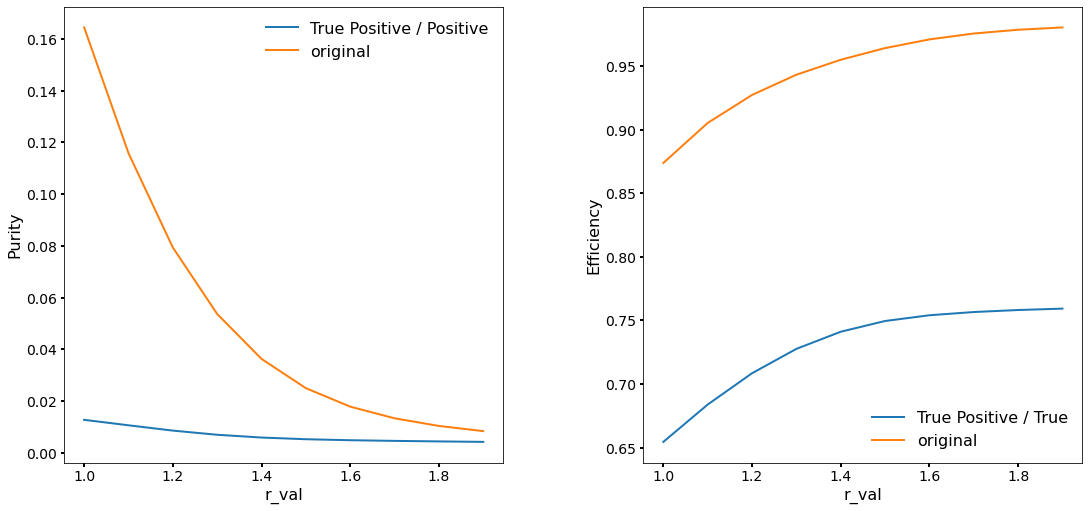

In [22]:
fig3, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig3.tight_layout(w_pad = 10)
# fig3.suptitle(f'Eventid {evtid}')
ax1.plot(rvals, p_val, label = 'True Positive / Positive')
ax1.plot(rvals, ogp_val, label = "original")
ax1.set_xlabel('r_val')
ax1.set_ylabel('Purity')
# ax1.set_xticks(rvals)
ax1.legend()

ax2.plot(rvals, e_val, label = 'True Positive / True')
ax2.plot(rvals, oge_val, label = "original")
ax2.set_xlabel('r_val')
ax2.set_ylabel('Efficiency')
# ax2.set_xticks(x)
ax2.legend()

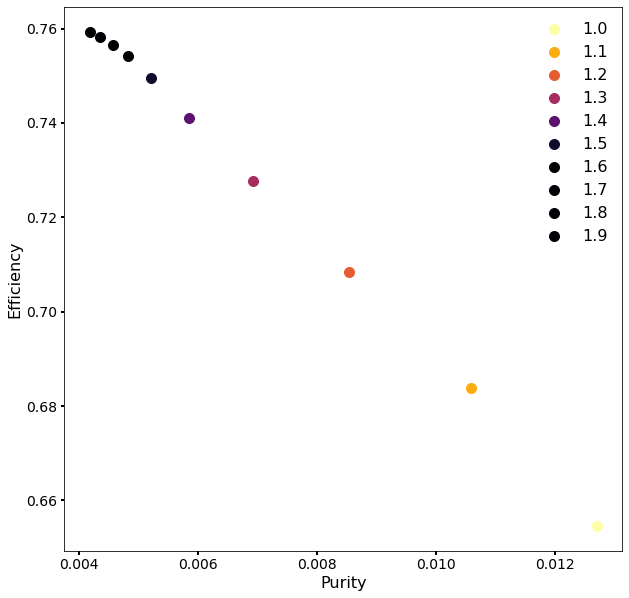

In [23]:
fig4, ax = plt.subplots(figsize=(10,10))
# fig4.suptitle(f'Eventid {evtid}, 100% noise, 1<rval<2, knn=500')
n = len(p_val)-1
colors = cm.inferno_r(np.linspace(0,n))
for i,val in enumerate(rvals):
    ax.scatter(p_val[i],e_val[i], color = colors[i], label = f'{val:.1f}')
ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.legend()

In [12]:
step = np.arange(400,500,10)
ogp_kval = []
oge_kval = []
data_path = "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n0/feature_store/"
for n in step:
    print(f"------ {n} ------")
    start = time.time()
    okpv,okev = get_lvl_emb(data_path,emb_model,knn_val=n.item())
    end = time.time()
    print(end-start)
    ogp_kval.append(okpv)
    oge_kval.append(okev)

------ 400 ------
-----------
cluster true = 98107
cluste true positive = 95650
cluster positive = 6307657
purity = 0.015164109272270195
efficiency = 0.9749559154800371
-----------
cluster true = 104909
cluste true positive = 102088
cluster positive = 7433363
purity = 0.013733756847338142
efficiency = 0.9731100286915326
-----------
cluster true = 116478
cluste true positive = 113539
cluster positive = 8633383
purity = 0.013151159863983793
efficiency = 0.9747677673036969
-----------
cluster true = 118662
cluste true positive = 115602
cluster positive = 8694227
purity = 0.01329640921498829
efficiency = 0.974212469029681
-----------
cluster true = 103195
cluste true positive = 100565
cluster positive = 6848167
purity = 0.01468495146219419
efficiency = 0.9745142691021852
353.3261196613312
------ 410 ------
-----------
cluster true = 98107
cluste true positive = 95661
cluster positive = 6346134
purity = 0.01507390168565618
efficiency = 0.9750680379585555
-----------
cluster true = 104909
cl

In [15]:
%%time
step = np.arange(100,500,50)
p_kval = []
e_kval = []
data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/shift_x_pre/1/feature_store/"
for n in step:
    print(f"------ {n} ------")
    start = time.time()
    pv,ev = get_lvl_emb(data_path,emb_model,knn_val=n.item())
    end = time.time()
    print(end-start)
    p_kval.append(pv)
    e_kval.append(ev)

------ 100 ------
-----------
cluster true = 113355
cluste true positive = 70005
cluster positive = 4520874
purity = 0.015484837666345048
efficiency = 0.6175731110228927
-----------
cluster true = 103417
cluste true positive = 64791
cluster positive = 4145147
purity = 0.01563056750460237
efficiency = 0.6265024125627314
-----------
cluster true = 144799
cluste true positive = 84160
cluster positive = 5877252
purity = 0.014319617399424084
efficiency = 0.5812194835599693
-----------
cluster true = 109855
cluste true positive = 67778
cluster positive = 4406809
purity = 0.015380289910454481
efficiency = 0.6169769241272587
-----------
cluster true = 120163
cluste true positive = 73388
cluster positive = 4861470
purity = 0.015095845495292576
efficiency = 0.6107370821301066
448.18880009651184
------ 150 ------
-----------
cluster true = 113355
cluste true positive = 74906
cluster positive = 6522422
purity = 0.011484384175080974
efficiency = 0.6608089629923691
-----------
cluster true = 103417


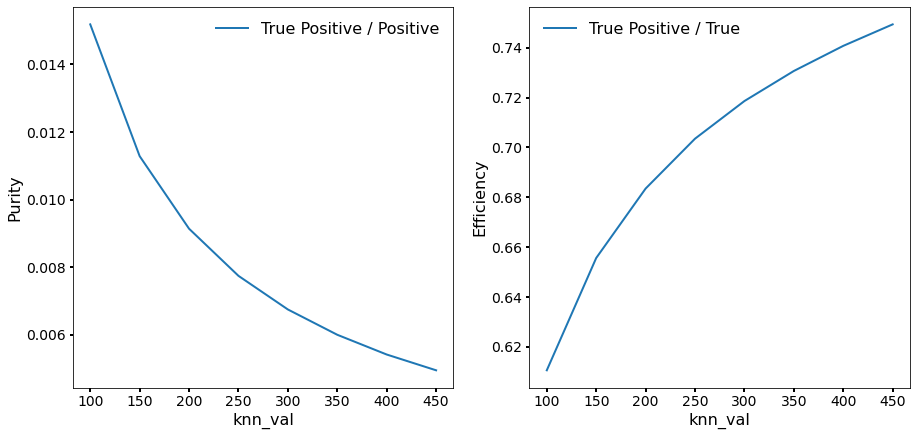

In [17]:
fig5, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
# fig5.suptitle(f'Eventid {evtid}, 100% noise, rval=1.7, 400,knnval,500')
ax1.plot(step, p_kval, label = 'True Positive / Positive')
# ax1.plot(step, ogp_kval, label = 'Original')
ax1.set_xlabel('knn_val')
ax1.set_ylabel('Purity')
ax1.legend()

ax2.plot(step, e_kval, label = 'True Positive / True')
# ax2.plot(step, oge_kval, label = 'Original')
ax2.set_xlabel('knn_val')
ax2.set_ylabel('Efficiency')
ax2.legend()

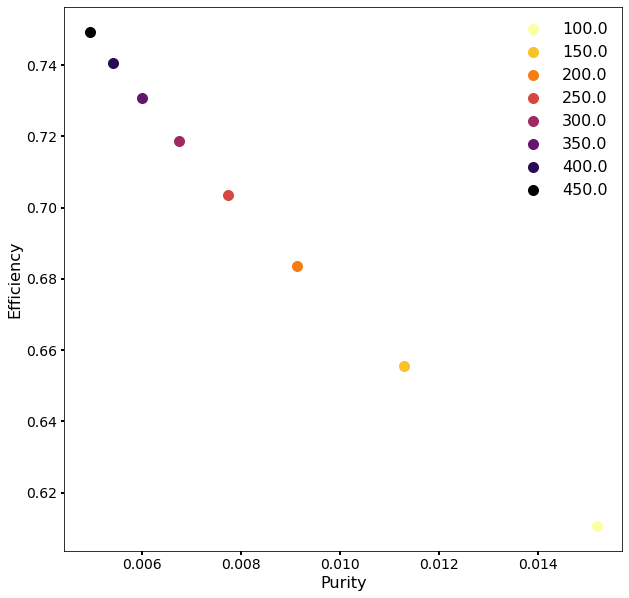

In [18]:
fig6, ax = plt.subplots(figsize=(10,10))
# fig6.suptitle(f'Eventid {evtid}, 100% noise, 1<rval<2, knn=500')
n = len(p_kval)-1
colors = cm.inferno_r(np.linspace(0,n))
for i,val in enumerate(step):
    ax.scatter(p_kval[i],e_kval[i], color = colors[i], label = f'{val:.1f}')
ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.legend()